## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online
data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values
data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger
def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable
def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats
data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables
data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set
data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
vars_num = data.columns[
    (data.dtypes != np.dtype('object')) & ~data.columns.isin([target])  # Do not include the target
].tolist()

vars_cat = data.columns[data.dtypes == np.dtype('object')].tolist()

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [11]:
# first in numerical variables
data[vars_num].isna().sum()

pclass      0
age       263
sibsp       0
parch       0
fare        1
dtype: int64

In [12]:
# now in categorical variables
data[vars_cat].isna().sum()

sex            0
cabin       1014
embarked       2
title          0
dtype: int64

In [13]:
# check there are no missing values in the target
data[[target]].isna().sum()

survived    0
dtype: int64

### Determine cardinality of categorical variables

In [14]:
data[vars_cat].apply(lambda col: col.nunique()).to_frame("Cardinality").rename_axis("Variable")

,Cardinality
Variable,
sex,2
cabin,181
embarked,3
title,5


### Determine the distribution of numerical variables

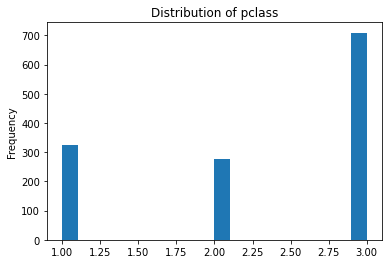

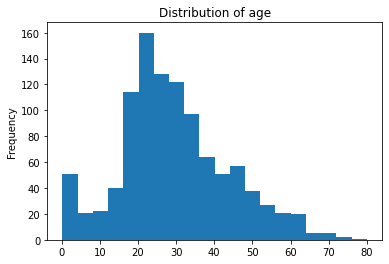

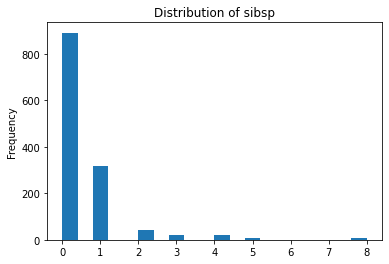

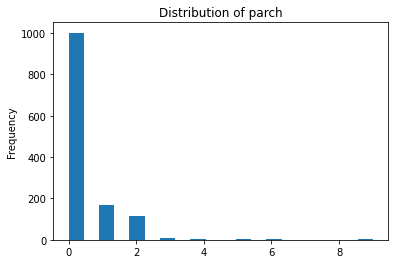

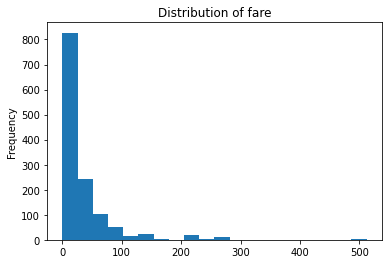

In [15]:
for col_name in vars_num:
    data[col_name].plot.hist(bins=20)
    plt.title(f"Distribution of {col_name}")
    plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [17]:
# Check "cabin" is always one character and then a number (or missing)
assert (data.query("~cabin.isna() & (cabin.str.len() > 1)").assign(
        cabin_letter=lambda df: df.cabin.str[:1],
        cabin_number=lambda df: df.cabin.str[1:],
    ).cabin_number.str.isnumeric() == True
).all()
print("Correct: 'cabin' is always of the form 'one character''number or missing'")

Correct: 'cabin' is always of the form 'one character''number or missing'


In [18]:
X_train['cabin'] = X_train.cabin.str[:1]
X_test['cabin'] = X_test.cabin.str[:1]

In [19]:
print(X_train.cabin.value_counts(dropna=True).sort_index())  # Check these are all letters

A    19
B    52
C    78
D    36
E    36
F    18
G     4
T     1
Name: cabin, dtype: int64


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [20]:
# Save original median values for numeric columns
median_var_dict = {
    col_name: X_train[col_name].median() for col_name in vars_num
}
np.save('median_var_dict.npy', median_var_dict)

In [21]:
# Fill missing values with the median in both train and test
for col_name, med_val in median_var_dict.items():
    if X_train[col_name].isna().sum() > 0:
        X_train[col_name + '_miss_ind'] = X_train[col_name].isna() + 0
        X_test[col_name + '_miss_ind'] = X_test[col_name].isna() + 0
        vars_num.append(col_name + '_miss_ind')
    X_train[col_name].fillna(med_val, inplace=True)
    X_test[col_name].fillna(med_val, inplace=True)

In [22]:
# Test that there are now no missing values
# and the median is the same
assert X_train[vars_num].isnull().sum().sum() == 0
assert X_test[vars_num].isnull().sum().sum() == 0
assert all([
    X_train[col_name].median() == med_val 
    for col_name, med_val in median_var_dict.items()
])
print("Correct: All reasonableness tests have passed")

Correct: All reasonableness tests have passed


### Replace Missing data in categorical variables with the string **Missing**

In [23]:
# Get number of missing to check against
original_missing = X_train[vars_cat].isna().sum()

In [24]:
# function to replace NA in categorical variables
def fill_categorical_na(df, var_list):
    X = df.copy()
    X[var_list] = df[var_list].fillna('Missing')
    return X

# replace missing values with new label: "Missing"
X_train = fill_categorical_na(X_train, vars_cat)
X_test = fill_categorical_na(X_test, vars_cat)

# check that we have no missing information in the engineered variables
assert X_train[vars_cat].isnull().sum().sum() == 0
assert X_test[vars_cat].isnull().sum().sum() == 0
assert X_train[vars_cat].apply(
    lambda col_sers: (col_sers == 'Missing').sum()
).equals(original_missing)
print("Correct: All reasonableness tests have passed")

Correct: All reasonableness tests have passed


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [25]:
def find_frequent_labels(df, var, rare_perc):
    # finds the labels that are shared by more than a certain % of the rows
    tmp = df[var].value_counts(normalize=True)
    return tmp[tmp>=rare_perc].index

In [26]:
# Get labels more frequent than 5% of the data
frequent_labels_dict = {
    col_name: find_frequent_labels(X_train, col_name, 0.05)
    for col_name in vars_cat
}
np.save('FrequentLabels.npy', frequent_labels_dict)

In [27]:
# Get original proportions of each level to compare against
original_props = {
    col_name: X_train[col_name].value_counts(normalize=True)
    for col_name in vars_cat
}

In [28]:
# Allocate labels less frequent than 5% to 'Rare' category
for col_name, frequent_ls in frequent_labels_dict.items():
    X_train[col_name] = np.where(
        X_train[col_name].isin(frequent_ls), X_train[col_name], 'Rare'
    )
    X_test[col_name] = np.where(
        X_test[col_name].isin(frequent_ls), X_test[col_name], 'Rare'
    )

In [29]:
# How many of the values have been converted to 'Rare' in each categorical column?
X_train[vars_cat].apply(lambda col_sers: (col_sers == 'Rare').value_counts())

,sex,cabin,embarked,title
False,1047.0,881,1045,973
True,NaN,166,2,74


In [30]:
# Check that the results are as expected
new_props = {
    col_name: X_train[col_name].value_counts(normalize=True)
    for col_name in vars_cat
}
col_name = vars_cat[0]
for col_name in vars_cat:
    display(
        original_props[col_name].to_frame('orig').merge(
            new_props[col_name].to_frame('new'),
            how='outer', left_index=True, right_index=True
        ).fillna(0).assign(
            check=lambda df: np.select(
                [df.index == 'Rare', df.orig < 0.05], 
                [df.new == df.orig[df.orig < 0.05].sum(), True], 
                default=(df.orig == df.new)
            )
        ).rename_axis(index=col_name)
    )

,orig,new,check
sex,,,
male,0.633238,0.633238,True
female,0.366762,0.366762,True


,orig,new,check
cabin,,,
A,0.018147,0.000000,True
B,0.049666,0.000000,True
C,0.074499,0.074499,True
D,0.034384,0.000000,True
E,0.034384,0.000000,True
F,0.017192,0.000000,True
G,0.003820,0.000000,True
Missing,0.766953,0.766953,True
Rare,0.000000,0.158548,True


,orig,new,check
embarked,,,
C,0.195798,0.195798,True
Missing,0.001910,0.000000,True
Q,0.092646,0.092646,True
Rare,0.000000,0.001910,True
S,0.709647,0.709647,True


,orig,new,check
title,,,
Master,0.044890,0.000000,True
Miss,0.200573,0.200573,True
Mr,0.569245,0.569245,True
Mrs,0.159503,0.159503,True
Other,0.025788,0.000000,True
Rare,0.000000,0.070678,True


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [31]:
expected_counts = {
    col_name: X_train[col_name].value_counts().sort_index()[1:].to_frame(
    ).reset_index().rename(columns={'index': 'level'}).assign(
        index=lambda df: col_name + '_' + df.level
    ).drop(columns='level').set_index('index')[col_name]
    for col_name in vars_cat
}

In [32]:
X_train = X_train.merge(
    pd.get_dummies(X_train[vars_cat], prefix=vars_cat, drop_first=True),
    left_index=True, right_index=True
).drop(columns=vars_cat)
X_test = X_test.merge(
    pd.get_dummies(X_test[vars_cat], prefix=vars_cat, drop_first=True),
    left_index=True, right_index=True
).drop(columns=vars_cat)

In [33]:
# Check the counts match as expected
assert all([
    X_train[counts_df.index].sum().equals(counts_df)
    for col_name, counts_df in expected_counts.items()
])
print("Correct: All counts match as expected")

Correct: All counts match as expected


In [34]:
# Ensure test data includes all the columns
for col_name in X_train.columns[~X_train.columns.isin(X_test.columns)]:
    X_test[col_name] = 0
X_test = X_test[X_train.columns]
assert (X_test.columns == X_train.columns).all()
print("Correct: X_test now has all the same columns as X_train")

Correct: X_test now has all the same columns as X_train


### Scale the variables

- Use the standard scaler from Scikit-learn

In [35]:
# fit scaler
scaler = StandardScaler() # create an instance
scaler.fit(X_train) #  fit the scaler to the train set for later use

# we persist the model for future use
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [36]:
# transform the train and test set
X_train = pd.DataFrame(scaler.transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [37]:
# train the model
log_model = LogisticRegression(C=0.0005, random_state=0) # remember to set the random_state / seed
log_model.fit(X_train, y_train)

# we persist the model for future use
joblib.dump(log_model, 'logistic_regression.pkl')

['logistic_regression.pkl']

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [38]:
pred_proba_train = log_model.predict_proba(X_train)[:, 1]
pred_proba_test = log_model.predict_proba(X_test)[:, 1]
print(f"ROC AUC on training data:\t{roc_auc_score(y_train, pred_proba_train):.2%}")
print(f"ROC AUC on test data:\t\t{roc_auc_score(y_test, pred_proba_test):.2%}")

ROC AUC on training data:	84.32%
ROC AUC on test data:		83.54%


In [39]:
pred_train = log_model.predict(X_train)
pred_test = log_model.predict(X_test)
print(f"Accuracy on training data:\t{accuracy_score(y_train, pred_train):.2%}")
print(f"Accuracy on test data:\t\t{accuracy_score(y_test, pred_test):.2%}")

Accuracy on training data:	71.25%
Accuracy on test data:		70.23%


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignment!!**